# Tianyi Zhang 9598110243
------------------

## 1. Supervised, Semi-Supervised, and Unsupervised Learning

### a)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split


In [2]:
import sys
import warnings

warnings.filterwarnings('ignore')
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [3]:
data_folder = '..\\data'

In [4]:
def generate_data():
    filename = os.path.join(data_folder, 'wdbc.data')

    df = pd.read_csv(filename, header = None)
    df = df.sample(frac=1).reset_index(drop=True)

    x = df.iloc[:, 2:]
    y = df.iloc[:, 1]

    
    return x, y

In [5]:
def split_train_test(x, y, ratio):
    xM = x[y == 'M']
    xB = x[y == 'B']
    yM = y[y == 'M']
    yB = y[y == 'B']


    xtr = np.concatenate((xM[round(len(xM) * ratio):], xB[round(len(xB) * ratio):]), axis = 0)
    ytr = np.concatenate((yM[round(len(xM) * ratio):], yB[round(len(xB) * ratio):]), axis = 0)
    xte = np.concatenate((xM[:round(len(xM) * ratio)], xB[:round(len(xB) * ratio)]), axis = 0)
    yte = np.concatenate((yM[:round(len(xM) * ratio)], yB[:round(len(xB) * ratio)]), axis = 0)
    
    return xtr, ytr, xte, yte

In [8]:
x, y = generate_data()

xtr, ytr, xte, yte = split_train_test(x, y, ratio = 0.2)

print("shape of training data and label:", xtr.shape, ytr.shape)
print("shape of test data and label:", xte.shape, yte.shape)

shape of training data and label: (456, 30) (456,)
shape of test data and label: (113, 30) (113,)


### b)

#### 1)

In [9]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import precision_recall_fscore_support as score, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from tqdm import tqdm

from sklearn.metrics import roc_curve, auc

In [10]:
parameters = {"C": np.logspace(-3, 6, 10)}

In [11]:
acc_train = []
acc_test = []

matrix_train = {}
precision_train = []
recall_train = []
f_train = []
auc_train = []

matrix_test = {}
precision_test = []
recall_test = []
f_test = []
auc_test = []


y_train = {}
y_test = {}
prediction_train = {}
prediction_test = {}

In [12]:
for i in range(30):
    x, y = generate_data()

    x = MinMaxScaler().fit(x).transform(x)

    xtr, ytr, xte, yte = split_train_test(x, y, ratio = 0.2)
    yte = np.array([0 if x == 'M' else 1 for x in yte])
    ytr = np.array([0 if x == 'M' else 1 for x in ytr])

    y_train[i] = ytr
    y_test[i] = yte

    l1_svc = LinearSVC(penalty="l1", dual=False, max_iter=5000)
    gridCV = GridSearchCV(l1_svc, parameters, cv=5, n_jobs=-1)
    gridCV.fit(xtr, ytr)

    bestClf = gridCV.best_estimator_
    pred_tr = bestClf.predict(xtr)
    pred_te = bestClf.predict(xte)
    prediction_train[i] = pred_tr
    prediction_test[i] = pred_te

    matrix_tr = pd.crosstab(ytr, pred_tr, rownames=['True'], colnames=['Predicted'], margins=True)
    matrix_te = pd.crosstab(yte, pred_te, rownames=['True'], colnames=['Predicted'], margins=True)
    matrix_train[i] = matrix_tr
    matrix_test[i] = matrix_te

    precision_tr, recall_tr, f_tr, _ = score(ytr, pred_tr, average='binary', pos_label=1)
    precision_te, recall_te, f_te, _ = score(yte, pred_te, average='binary', pos_label=1)

    precision_train.append(precision_tr)
    recall_train.append(recall_tr)
    f_train.append(f_tr)
    precision_test.append(precision_te)
    recall_test.append(recall_te)
    f_test.append(f_te)

    fp_tr, tp_tr, _ = roc_curve(ytr, pred_tr)
    auc_tr = auc(fp_tr, tp_tr)
    auc_train.append(auc_tr)

    fp_te, tp_te, _ = roc_curve(yte, pred_te)
    auc_te = auc(fp_te, tp_te)
    auc_test.append(auc_te)

    acc_train.append(accuracy_score(ytr, pred_tr))
    acc_test.append(accuracy_score(yte, pred_te))


**For training data:**

In [13]:
print("average accuracy: ", np.average(acc_train))
print("average precision: ", np.average(precision_train))
print("average recall: ", np.average(recall_train))
print("average F1 -Score: ", np.average(f_train))
print("average AUC: ", np.average(auc_train))

average accuracy:  0.9861111111111109
average precision:  0.9834271025490274
average recall:  0.9946386946386947
average F1 -Score:  0.9889932817562879
average AUC:  0.9832017002605238


In [14]:
index = np.argmax(acc_train)
print("training confusion matrix:")
print("---------------")
print(matrix_train[index])

training confusion matrix:
---------------
Predicted    0    1  All
True                    
0          170    0  170
1            0  286  286
All        170  286  456


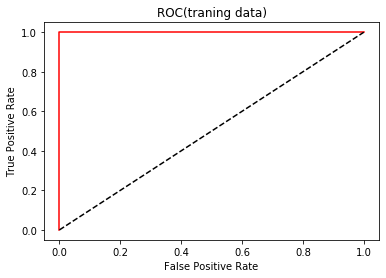

---------------
auc(training data):  1.0


In [15]:
fp, tp, thresholds = roc_curve(y_train[index], prediction_train[index])
area = auc(fp, tp)
plt.plot(fp, tp, color='red')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC(traning data)")
plt.show()
print("---------------")
print("auc(training data): ", area)

**For test data:**

In [16]:
print("average accuracy: ", np.average(acc_test))
print("average precision: ", np.average(precision_test))
print("average recall: ", np.average(recall_test))
print("average F1 -Score: ", np.average(f_test))
print("average AUC: ", np.average(auc_test))

average accuracy:  0.9663716814159292
average precision:  0.9636579391791293
average recall:  0.9840375586854461
average F1 -Score:  0.9735868231094006
average AUC:  0.9602727475966913


In [17]:
print("training confusion matrix:")
print("---------------")
print(matrix_test[index])

training confusion matrix:
---------------
Predicted   0   1  All
True                  
0          38   4   42
1           1  70   71
All        39  74  113


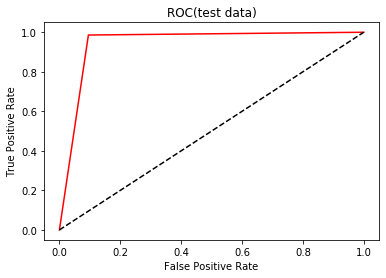

---------------
auc(test data):  0.9453386988598257


In [18]:
fp, tp, thresholds = roc_curve(y_test[index], prediction_test[index])
area = auc(fp, tp)
plt.plot(fp, tp, color='red')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC(test data)")
plt.show()
print("---------------")
print("auc(test data): ", area)

#### 2)

##### A)

In [19]:
x, y = generate_data()

x = MinMaxScaler().fit(x).transform(x)
xtr, ytr, xte, yte = split_train_test(x, y, ratio = 0.2)
label_x, label_y, unlabel_x, unlabel = split_train_test(xtr, ytr, ratio = 0.5)

In [20]:
l1_svc = LinearSVC(penalty="l1", dual=False, max_iter=5000)
gridCV = GridSearchCV(l1_svc, parameters, cv=5, n_jobs=-1)
gridCV.fit(label_x, label_y)

print("best penalty parameter: ", gridCV.best_params_)
print("test score:", gridCV.score(xte, yte))

best penalty parameter:  {'C': 10.0}
test score: 0.9469026548672567


##### B)

In [21]:
acc_train = []
acc_test = []

matrix_train = {}
precision_train = []
recall_train = []
f_train = []
auc_train = []

matrix_test = {}
precision_test = []
recall_test = []
f_test = []
auc_test = []


y_train = {}
y_test = {}
prediction_train = {}
prediction_test = {}

In [25]:
def semi_learning(label_xtr, label_ytr, unlabel_xtr, bestClf):
    for _ in range(unlabel_xtr.shape[0]):
        distance = np.absolute(bestClf.decision_function(unlabel_xtr))
        maxIndex = np.argmax(distance)
        datapoint = np.array(unlabel_xtr[maxIndex]).reshape(1, 30)
        pred = bestClf.predict(datapoint)

        unlabel_xtr = np.delete(unlabel_xtr, maxIndex, axis=0)
        label_xtr = np.append(label_xtr, datapoint, axis=0)
        label_ytr = np.append(label_ytr, pred, axis=0)

        bestClf.fit(label_xtr, label_ytr)
    return bestClf

In [34]:
for i in range(30):
    x, y = generate_data()

    x = MinMaxScaler().fit(x).transform(x)

    xtr, ytr, xte, yte = split_train_test(x, y, ratio = 0.2)
    label_xtr, label_ytr, unlabel_xtr, unlabel = split_train_test(xtr, ytr, ratio = 0.5)
    yte = np.array([0 if x == 'M' else 1 for x in yte])
    label_ytr = np.array([0 if x == 'M' else 1 for x in label_ytr])
    y_train[i] = label_ytr
    y_test[i] = yte
    
    l1_svc = LinearSVC(penalty="l1", dual=False, max_iter=5000)
    gridCV = GridSearchCV(l1_svc, parameters, cv=5, n_jobs=-1)
    gridCV.fit(label_xtr, label_ytr)
    
    bestClf = gridCV.best_estimator_
    bestClf = semi_learning(label_xtr.copy(), label_ytr.copy(), unlabel_xtr.copy(), bestClf)

    pred_tr = bestClf.predict(label_xtr)
    pred_te = bestClf.predict(xte)
    prediction_train[i] = pred_tr
    prediction_test[i] = pred_te

    matrix_tr = pd.crosstab(label_ytr, pred_tr, rownames=['True'], colnames=['Predicted'], margins=True)
    matrix_te = pd.crosstab(yte, pred_te, rownames=['True'], colnames=['Predicted'], margins=True)
    matrix_train[i] = matrix_tr
    matrix_test[i] = matrix_te

    precision_tr, recall_tr, f_tr, _ = score(label_ytr, pred_tr, average='binary', pos_label=1)
    precision_te, recall_te, f_te, _ = score(yte, pred_te, average='binary', pos_label=1)

    precision_train.append(precision_tr)
    recall_train.append(recall_tr)
    f_train.append(f_tr)
    precision_test.append(precision_te)
    recall_test.append(recall_te)
    f_test.append(f_te)

    fp_tr, tp_tr, _ = roc_curve(label_ytr, pred_tr)
    auc_tr = auc(fp_tr, tp_tr)
    auc_train.append(auc_tr)

    fp_te, tp_te, _ = roc_curve(yte, pred_te)
    auc_te = auc(fp_te, tp_te)
    auc_test.append(auc_te)

    acc_train.append(accuracy_score(label_ytr, pred_tr))
    acc_test.append(accuracy_score(yte, pred_te))


**For training data:**

In [35]:
print("average accuracy: ", np.average(acc_train))
print("average precision: ", np.average(precision_train))
print("average recall: ", np.average(recall_train))
print("average F1 -Score: ", np.average(f_train))
print("average AUC: ", np.average(auc_train))

average accuracy:  0.985233918128655
average precision:  0.9801923375708036
average recall:  0.9967365967365966
average F1 -Score:  0.9883639436862299
average AUC:  0.9813094748388865


In [36]:
index = np.argmax(acc_train)
print("training confusion matrix:")
print("---------------")
print(matrix_train[index])

training confusion matrix:
---------------
Predicted   0    1  All
True                   
0          85    0   85
1           0  143  143
All        85  143  228


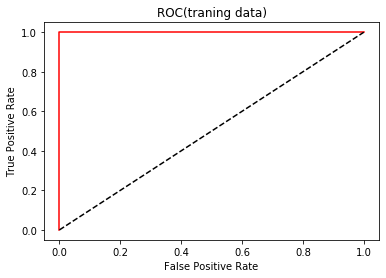

---------------
auc(training data):  1.0


In [40]:
fp, tp, thresholds = roc_curve(y_train[index], prediction_train[index])
area = auc(fp, tp)
plt.plot(fp, tp, color='red')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC(traning data)")
plt.show()
print("---------------")
print("auc(training data): ", area)

**For test data:**

In [41]:
print("average accuracy: ", np.average(acc_test))
print("average precision: ", np.average(precision_test))
print("average recall: ", np.average(recall_test))
print("average F1 -Score: ", np.average(f_test))
print("average AUC: ", np.average(auc_test))

average accuracy:  0.9697640117994101
average precision:  0.9657600870832346
average recall:  0.9873239436619717
average F1 -Score:  0.9762542260232919
average AUC:  0.9637016543706685


In [42]:
print("training confusion matrix:")
print("---------------")
print(matrix_test[index])

training confusion matrix:
---------------
Predicted   0   1  All
True                  
0          40   2   42
1           0  71   71
All        40  73  113


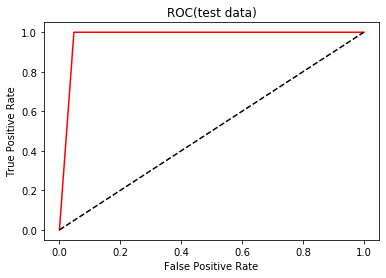

---------------
auc(test data):  0.9761904761904762


In [43]:
fp, tp, thresholds = roc_curve(y_test[index], prediction_test[index])
area = auc(fp, tp)
plt.plot(fp, tp, color='red')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC(test data)")
plt.show()
print("---------------")
print("auc(test data): ", area)

#### 3)

##### A)

In [44]:
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans

In [45]:
acc_train = []

precision_train = []
recall_train = []
f_train = []
auc_train = []

In [46]:
for i in range(30):
    x, y = generate_data()

    x = MinMaxScaler().fit(x).transform(x)

    xtr, ytr, xte, yte = split_train_test(x, y, ratio = 0.2)
    yte = np.array([0 if x == 'M' else 1 for x in yte])
    ytr = np.array([0 if x == 'M' else 1 for x in ytr])

    kmeansClf = KMeans(n_clusters=2, init='random', n_init=10)
    cluster_tr = kmeansClf.fit_predict(xtr)

    precision_tr, recall_tr, f_tr, _ = score(ytr, cluster_tr, average='binary', pos_label=1)

    precision_train.append(precision_tr)
    recall_train.append(recall_tr)
    f_train.append(f_tr)
   
    fp_tr, tp_tr, _ = roc_curve(ytr, cluster_tr)
    auc_tr = auc(fp_tr, tp_tr)
    auc_train.append(auc_tr)

    acc_train.append(accuracy_score(ytr, cluster_tr))

In [48]:
print("max accuracy: ", np.max(acc_train))
print("max precision: ", np.max(precision_train))
print("max recall: ", np.max(recall_train))
print("max F1 -Score: ", np.max(f_train))
print("max AUC: ", np.max(auc_train))

max accuracy:  0.9342105263157895
max precision:  0.9235880398671097
max recall:  0.986013986013986
max F1 -Score:  0.9491525423728813
max AUC:  0.918922254216372


**To avoid trapped in a local minimum, we can set the random seed and run multiple times.**

##### B)

In [79]:
acc_train = []

matrix_train = {}
precision_train = []
recall_train = []
f_train = []
auc_train = []
prediction_train = {}
y_train = {}

In [80]:
from collections import Counter

In [81]:
for i in range(30):
    x, y = generate_data()

    x = MinMaxScaler().fit(x).transform(x)

    xtr, ytr, xte, yte = split_train_test(x, y, ratio = 0.2)
    yte = np.array([0 if x == 'M' else 1 for x in yte])
    ytr = np.array([0 if x == 'M' else 1 for x in ytr])

    kmeansClf = KMeans(n_clusters=2, init='random', n_init=10)
    cluster_tr = kmeansClf.fit_predict(xtr)

    posIndex = np.argsort(cdist(xtr, kmeansClf.cluster_centers_, 'euclidean')[:, 0], axis=0)[:30]
    negIndex = np.argsort(cdist(xtr, kmeansClf.cluster_centers_, 'euclidean')[:, 1], axis=0)[:30]

    ytr_pos_near = ytr[posIndex]
    ytr_neg_near = ytr[negIndex]
    pos = Counter(ytr_pos_near).most_common(1)[0][0]
    neg = Counter(ytr_neg_near).most_common(1)[0][0]
    
    majorityPolling = np.vectorize(lambda x: pos if x == 0 else neg)
    labels = majorityPolling(cluster_tr)
    
    prediction_train[i] = labels
    y_train[i] = ytr

    matrix_train[i] = pd.crosstab(ytr, labels, rownames=['True'], colnames=['Predicted'], margins=True)
    precision_tr, recall_tr, f_tr, _ = score(ytr, labels, average='binary', pos_label=1)

    precision_train.append(precision_tr)
    recall_train.append(recall_tr)
    f_train.append(f_tr)
   
    fp_tr, tp_tr, _ = roc_curve(ytr, labels)
    auc_tr = auc(fp_tr, tp_tr)
    auc_train.append(auc_tr)

    acc_train.append(accuracy_score(ytr, labels))

In [82]:
print("average accuracy: ", np.average(acc_train))
print("average precision: ", np.average(precision_train))
print("average recall: ", np.average(recall_train))
print("average F1 -Score: ", np.average(f_train))
print("average AUC: ", np.average(auc_train))

average accuracy:  0.926461988304094
average precision:  0.914591780399377
average recall:  0.973776223776224
average F1 -Score:  0.9432182258095253
average AUC:  0.9103194844371314


In [83]:
index = np.argmax(acc_train)
print("training confusion matrix:")
print("---------------")
print(matrix_train[index])

training confusion matrix:
---------------
Predicted    0    1  All
True                    
0          144   26  170
1            3  283  286
All        147  309  456


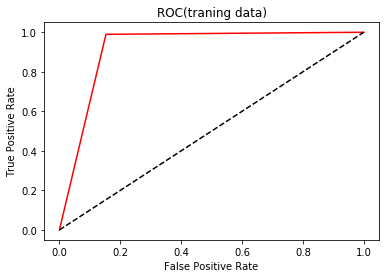

---------------
auc(training data):  0.9182846565199507


In [84]:
fp, tp, thresholds = roc_curve(y_train[index], prediction_train[index])
area = auc(fp, tp)
plt.plot(fp, tp, color='red')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC(traning data)")
plt.show()
print("---------------")
print("auc(training data): ", area)

##### C)

In [98]:
acc_test = []

matrix_test = {}
precision_test = []
recall_test = []
f_test = []
auc_test = []
prediction_test = {}
y_test = {}

In [99]:
for i in range(30):
    x, y = generate_data()

    x = MinMaxScaler().fit(x).transform(x)

    xtr, ytr, xte, yte = split_train_test(x, y, ratio = 0.2)
    yte = np.array([0 if x == 'M' else 1 for x in yte])
    ytr = np.array([0 if x == 'M' else 1 for x in ytr])

    kmeansClf = KMeans(n_clusters=2, init='random', n_init=10)
    cluster_te = kmeansClf.fit_predict(xte)

    posDist = cdist(xte, kmeansClf.cluster_centers_, 'euclidean')[:, 0]
    negDist = cdist(xte, kmeansClf.cluster_centers_, 'euclidean')[:, 1]
    
    prediction_te = []
    for index, pred in enumerate(cluster_te):
        if pred == 1:
            prediction_te.append(1 if abs(posDist[index]) < abs(negDist[index]) else 0)
        else:
            prediction_te.append(0 if abs(posDist[index]) > abs(negDist[index]) else 1)
    
    majority = Counter(prediction_te).most_common(1)[0][0]
    if majority != 1:
        flip = np.vectorize(lambda x: 1 if x == 0 else 0)
        prediction_te = flip(prediction_te).tolist()
    prediction_test[i] = prediction_te
    y_test[i]= yte

    matrix_test[i] = pd.crosstab(yte, np.reshape(prediction_te, (-1,)), rownames=['True'], colnames=['Predicted'], margins=True)
    precision_te, recall_te, f_te, _ = score(yte, prediction_te, average='binary', pos_label=1)

    precision_test.append(precision_te)
    recall_test.append(recall_te)
    f_test.append(f_te)
   
    fp_te, tp_te, _ = roc_curve(yte, prediction_te)
    auc_te = auc(fp_te, tp_te)
    auc_test.append(auc_te)

    acc_test.append(accuracy_score(yte, prediction_te))

In [100]:
print("average accuracy: ", np.average(acc_test))
print("average precision: ", np.average(precision_test))
print("average recall: ", np.average(recall_test))
print("average F1 -Score: ", np.average(f_test))
print("average AUC: ", np.average(auc_test))

average accuracy:  0.9271386430678467
average precision:  0.9159988759831589
average recall:  0.975117370892019
average F1 -Score:  0.9441625440088314
average AUC:  0.9105745584618822


In [101]:
index = np.argmax(acc_test)
print("test confusion matrix:")
print("---------------")
print(matrix_test[index])

test confusion matrix:
---------------
Predicted   0   1  All
True                  
0          41   1   42
1           0  71   71
All        41  72  113


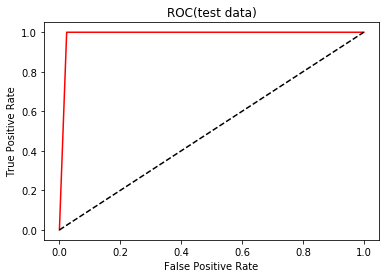

---------------
auc(test data):  0.988095238095238


In [103]:
fp, tp, thresholds = roc_curve(y_test[index], prediction_test[index])
area = auc(fp, tp)
plt.plot(fp, tp, color='red')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC(test data)")
plt.show()
print("---------------")
print("auc(test data): ", area)

#### 4)

##### A)

In [104]:
from sklearn.cluster import SpectralClustering

In [105]:
acc_train = []

precision_train = []
recall_train = []
f_train = []
auc_train = []

In [106]:
for i in range(30):
    x, y = generate_data()

    x = MinMaxScaler().fit(x).transform(x)

    xtr, ytr, xte, yte = split_train_test(x, y, ratio = 0.2)
    yte = np.array([0 if x == 'M' else 1 for x in yte])
    ytr = np.array([0 if x == 'M' else 1 for x in ytr])

    spectralClf = SpectralClustering(n_clusters=2, affinity="rbf", n_init=10, gamma=1)
    cluster_tr = spectralClf.fit_predict(xtr)

    precision_tr, recall_tr, f_tr, _ = score(ytr, cluster_tr, average='binary', pos_label=1)

    precision_train.append(precision_tr)
    recall_train.append(recall_tr)
    f_train.append(f_tr)
   
    fp_tr, tp_tr, _ = roc_curve(ytr, cluster_tr)
    auc_tr = auc(fp_tr, tp_tr)
    auc_train.append(auc_tr)

    acc_train.append(accuracy_score(ytr, cluster_tr))

In [107]:
print("max accuracy: ", np.max(acc_train))
print("max precision: ", np.max(precision_train))
print("max recall: ", np.max(recall_train))
print("max F1 -Score: ", np.max(f_train))
print("max AUC: ", np.max(auc_train))

max accuracy:  0.8903508771929824
max precision:  0.8575757575757575
max recall:  1.0
max F1 -Score:  0.9188311688311689
max AUC:  0.8565199506375978


##### B)

In [109]:
acc_train = []

matrix_train = {}
precision_train = []
recall_train = []
f_train = []
auc_train = []
prediction_train = {}
y_train = {}

In [111]:
for i in range(30):
    x, y = generate_data()

    x = MinMaxScaler().fit(x).transform(x)

    xtr, ytr, xte, yte = split_train_test(x, y, ratio = 0.2)
    yte = np.array([0 if x == 'M' else 1 for x in yte])
    ytr = np.array([0 if x == 'M' else 1 for x in ytr])

    spectralClf = SpectralClustering(n_clusters=2, affinity="rbf", n_init=10, gamma=1)
    cluster_tr = spectralClf.fit_predict(xtr)

    posIndex = np.argwhere(cluster_tr == 1).reshape(-1, )
    negIndex = np.argwhere(cluster_tr == 0).reshape(-1, )

    ytr_pos = ytr[posIndex]
    ytr_neg = ytr[negIndex]
    pos = Counter(ytr_pos).most_common(1)[0][0]
    neg = Counter(ytr_neg).most_common(1)[0][0]
    cluster_tr[posIndex] = pos
    cluster_tr[negIndex] = neg

    
    prediction_train[i] = cluster_tr
    y_train[i] = ytr

    matrix_train[i] = pd.crosstab(ytr, cluster_tr, rownames=['True'], colnames=['Predicted'], margins=True)
    precision_tr, recall_tr, f_tr, _ = score(ytr, cluster_tr, average='binary', pos_label=1)

    precision_train.append(precision_tr)
    recall_train.append(recall_tr)
    f_train.append(f_tr)
   
    fp_tr, tp_tr, _ = roc_curve(ytr, cluster_tr)
    auc_tr = auc(fp_tr, tp_tr)
    auc_train.append(auc_tr)

    acc_train.append(accuracy_score(ytr, cluster_tr))

In [112]:
print("average accuracy: ", np.average(acc_train))
print("average precision: ", np.average(precision_train))
print("average recall: ", np.average(recall_train))
print("average F1 -Score: ", np.average(f_train))
print("average AUC: ", np.average(auc_train))

average accuracy:  0.8603801169590642
average precision:  0.8222632999947657
average recall:  0.992890442890443
average F1 -Score:  0.8993817390232699
average AUC:  0.8151707116413001


In [113]:
index = np.argmax(acc_train)
print("training confusion matrix:")
print("---------------")
print(matrix_train[index])

training confusion matrix:
---------------
Predicted    0    1  All
True                    
0          123   47  170
1            2  284  286
All        125  331  456


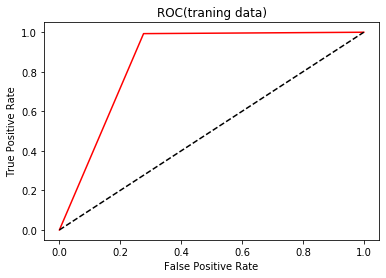

---------------
auc(training data):  0.8582682023858493


In [114]:
fp, tp, thresholds = roc_curve(y_train[index], prediction_train[index])
area = auc(fp, tp)
plt.plot(fp, tp, color='red')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC(traning data)")
plt.show()
print("---------------")
print("auc(training data): ", area)

##### C)

In [115]:
acc_test = []

matrix_test = {}
precision_test = []
recall_test = []
f_test = []
auc_test = []
prediction_test = {}
y_test = {}

In [116]:
for i in range(30):
    x, y = generate_data()

    x = MinMaxScaler().fit(x).transform(x)

    xtr, ytr, xte, yte = split_train_test(x, y, ratio = 0.2)
    yte = np.array([0 if x == 'M' else 1 for x in yte])
    ytr = np.array([0 if x == 'M' else 1 for x in ytr])

    spectralClf = SpectralClustering(n_clusters=2, affinity="rbf", n_init=10, gamma=1)
    cluster_te = spectralClf.fit_predict(xte)

    posIndex = np.argwhere(cluster_te == 1).reshape(-1, )
    negIndex = np.argwhere(cluster_te == 0).reshape(-1, )

    yte_pos = yte[posIndex]
    yte_neg = yte[negIndex]
    pos = Counter(yte_pos).most_common(1)[0][0]
    neg = Counter(yte_neg).most_common(1)[0][0]
    cluster_te[posIndex] = pos
    cluster_te[negIndex] = neg
    
    prediction_test[i] = prediction_te
    y_test[i]= yte

    matrix_test[i] = pd.crosstab(yte, cluster_te, rownames=['True'], colnames=['Predicted'], margins=True)
    precision_te, recall_te, f_te, _ = score(yte, cluster_te, average='binary', pos_label=1)

    precision_test.append(precision_te)
    recall_test.append(recall_te)
    f_test.append(f_te)
   
    fp_te, tp_te, _ = roc_curve(yte, cluster_te)
    auc_te = auc(fp_te, tp_te)
    auc_test.append(auc_te)

    acc_test.append(accuracy_score(yte, cluster_te))

In [117]:
print("average accuracy: ", np.average(acc_test))
print("average precision: ", np.average(precision_test))
print("average recall: ", np.average(recall_test))
print("average F1 -Score: ", np.average(f_test))
print("average AUC: ", np.average(auc_test))

average accuracy:  0.8330383480825959
average precision:  0.8012918090914536
average recall:  0.996244131455399
average F1 -Score:  0.8855975300584114
average AUC:  0.776693494299128


In [118]:
index = np.argmax(acc_test)
print("test confusion matrix:")
print("---------------")
print(matrix_test[index])

test confusion matrix:
---------------
Predicted   0   1  All
True                  
0          35   7   42
1           0  71   71
All        35  78  113


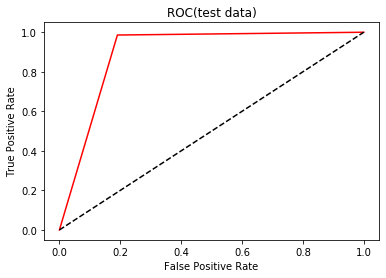

---------------
auc(test data):  0.897719651240778


In [119]:
fp, tp, thresholds = roc_curve(y_test[index], prediction_test[index])
area = auc(fp, tp)
plt.plot(fp, tp, color='red')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC(test data)")
plt.show()
print("---------------")
print("auc(test data): ", area)

#### 5)

**For supervised learning(test data):**

average accuracy:  0.9663716814159292

average precision:  0.9636579391791293

average recall:  0.9840375586854461

average F1 -Score:  0.9735868231094006

average AUC:  0.9602727475966913

**For semi-supervised learning(test data):**

average accuracy:  0.9697640117994101

average precision:  0.9657600870832346

average recall:  0.9873239436619717

average F1 -Score:  0.9762542260232919

average AUC:  0.9637016543706685

**For unsupervised learning:**

average accuracy:  0.9271386430678467

average precision:  0.9159988759831589

average recall:  0.975117370892019

average F1 -Score:  0.9441625440088314

average AUC:  0.9105745584618822

**We can find that supervised and semi-supervised learning perform very well, and they are better than unsupervised learning.**

## 2. Active Learning Using Support Vector Machines

### a)

In [173]:
filename2 = os.path.join(data_folder, 'data_banknote_authentication.txt')

In [174]:
from sklearn.preprocessing import StandardScaler

In [175]:
df2 = pd.read_csv(filename2, header = None)
print(df2.head())

         0       1       2        3  4
0  3.62160  8.6661 -2.8073 -0.44699  0
1  4.54590  8.1674 -2.4586 -1.46210  0
2  3.86600 -2.6383  1.9242  0.10645  0
3  3.45660  9.5228 -4.0112 -3.59440  0
4  0.32924 -4.4552  4.5718 -0.98880  0


In [176]:
data = df2.sample(frac=1).reset_index(drop=True)

x = data.iloc[:, :4]
y = data.iloc[:, 4].to_numpy()
x = StandardScaler().fit(x).transform(x)

xte = x[:472]
xtr = x[472:]
yte = y[:472]
ytr = y[472:]

print("shape of training data:", xtr.shape, ytr.shape)
print("shape of test data:", xte.shape, yte.shape)

shape of training data: (900, 4) (900,)
shape of test data: (472, 4) (472,)


### b)

#### 1)

In [177]:
error_pass = []

In [178]:
import random

In [ ]:
for i in tqdm(range(50)):
    error = []
    length = len(xtr)
    index = np.arange(0, length)
    
    xtr_pool = np.array([[]])
    ytr_pool = np.array([])
    
    for __ in range(90):
        indexes = random.sample(index.tolist(), 10)
        check = True if len(Counter(ytr[indexes]).keys()) == 2 else False
        while not check:
            indexes = random.sample(index.tolist(), 10)
            check = True if len(Counter(ytr[indexes]).keys()) == 2 else False
        index = np.setdiff1d(index, np.array(indexes))
        
        xtr_pool = np.append(xtr_pool, xtr[indexes]).reshape(-1, 4)
        ytr_pool = np.append(ytr_pool, ytr[indexes]).reshape(-1, )
        l1_scv = LinearSVC(penalty="l1", dual=False, max_iter=5000)
        gridCV = GridSearchCV(l1_scv, parameters, cv=5, n_jobs=-1, scoring='accuracy')
        gridCV.fit(xtr_pool, ytr_pool)
        error.append(1 - gridCV.score(xte, yte))

    error_pass.append(error)

In [182]:
print(error_pass)

[[0.423728813559322, 0.05084745762711862, 0.05508474576271183, 0.03177966101694918, 0.03813559322033899, 0.029661016949152574, 0.02754237288135597, 0.03389830508474578, 0.016949152542372836, 0.029661016949152574, 0.016949152542372836, 0.03389830508474578, 0.016949152542372836, 0.02330508474576276, 0.03177966101694918, 0.03389830508474578, 0.03177966101694918, 0.029661016949152574, 0.02754237288135597, 0.01906779661016944, 0.02754237288135597, 0.02754237288135597, 0.01906779661016944, 0.01906779661016944, 0.01906779661016944, 0.01906779661016944, 0.01906779661016944, 0.01906779661016944, 0.02754237288135597, 0.021186440677966156, 0.021186440677966156, 0.02754237288135597, 0.021186440677966156, 0.02754237288135597, 0.02754237288135597, 0.016949152542372836, 0.016949152542372836, 0.016949152542372836, 0.016949152542372836, 0.021186440677966156, 0.016949152542372836, 0.016949152542372836, 0.016949152542372836, 0.016949152542372836, 0.016949152542372836, 0.016949152542372836, 0.019067796610

#### 2)

In [183]:
error_act = []

In [184]:
for i in tqdm(range(50)):
    error = []
    length = len(xtr)
    index = np.arange(0, length)
    
    xtr_pool = np.array([[]])
    ytr_pool = np.array([])
    
    indexes = random.sample(index.tolist(), 10)
    check = True if len(Counter(ytr[indexes]).keys()) == 2 else False
    while not check:
        indexes = random.sample(index.tolist(), 10)
        check = True if len(Counter(ytr[indexes]).keys()) == 2 else False
    index = np.setdiff1d(index, np.array(indexes))

    xtr_pool = np.append(xtr_pool, xtr[indexes]).reshape(-1, 4)
    ytr_pool = np.append(ytr_pool, ytr[indexes]).reshape(-1, )
    l1_scv = LinearSVC(penalty="l1", dual=False, max_iter=5000)
    gridCV = GridSearchCV(l1_scv, parameters, cv=5, n_jobs=-1, scoring='accuracy')
    gridCV.fit(xtr_pool, ytr_pool)
    error.append(1 - gridCV.score(xte, yte))
        
    for __ in range(89):
        x_remaining = xtr[index]
        distances = gridCV.best_estimator_.decision_function(x_remaining).reshape(-1, 1)
        x_remaining = np.hstack((x_remaining, abs(distances)))
        indexes_near = x_remaining[:, 4].argsort()[:10]
        x_near = xtr[indexes_near]
        y_near = ytr[indexes_near]
        index = np.setdiff1d(index, np.array(indexes_near))
        
        xtr_pool = np.append(xtr_pool, x_near).reshape(-1, 4)
        ytr_pool = np.append(ytr_pool, y_near).reshape(-1, )

        l1_scv = LinearSVC(penalty="l1", dual=False, max_iter=5000)
        gridCV = GridSearchCV(l1_scv, parameters, cv=5, n_jobs=-1, scoring='accuracy')
        gridCV.fit(xtr_pool, ytr_pool)
        error.append(1 - gridCV.score(xte, yte))

    error_act.append(error)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [26:15<00:00, 31.50s/it]


In [185]:
print(error_act)

[[0.2076271186440678, 0.029661016949152574, 0.02754237288135597, 0.029661016949152574, 0.025423728813559365, 0.01906779661016944, 0.01906779661016944, 0.01906779661016944, 0.03601694915254239, 0.03177966101694918, 0.02754237288135597, 0.02754237288135597, 0.03177966101694918, 0.014830508474576232, 0.012711864406779627, 0.012711864406779627, 0.010593220338983023, 0.016949152542372836, 0.016949152542372836, 0.016949152542372836, 0.016949152542372836, 0.008474576271186418, 0.016949152542372836, 0.008474576271186418, 0.02330508474576276, 0.02330508474576276, 0.02754237288135597, 0.02330508474576276, 0.010593220338983023, 0.010593220338983023, 0.010593220338983023, 0.010593220338983023, 0.014830508474576232, 0.014830508474576232, 0.010593220338983023, 0.010593220338983023, 0.008474576271186418, 0.016949152542372836, 0.016949152542372836, 0.021186440677966156, 0.021186440677966156, 0.02330508474576276, 0.02330508474576276, 0.02330508474576276, 0.012711864406779627, 0.014830508474576232, 0.01

### c)

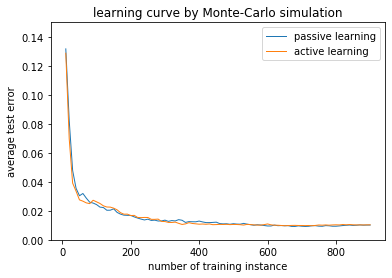

In [186]:
avg_error_pass = np.average(np.array(error_pass), axis=0)
avg_error_act = np.average(np.array(error_act), axis=0)
plt.plot(np.arange(10, 901, 10), avg_error_pass, marker='', linewidth=1, label="passive learning")
plt.plot(np.arange(10, 901, 10), avg_error_act, marker='', linewidth=1, label="active learning")
plt.xlabel('number of training instance')
plt.ylabel('average test error')
plt.ylim([0, 0.15])
plt.title("learning curve by Monte-Carlo simulation")
plt.legend()
plt.show()